In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# zip 파일을 위한 모듈
import os
import io
import zipfile
from zipfile import ZipFile

In [2]:
# open할 데이터 파일
!ls ../data/

open.zip  test.csv  train.csv


In [3]:
# 압축된 파일들의 리스트 확인하기
with ZipFile('../data/open.zip','r') as zipObj:
    listOfFileNames = zipObj.namelist()
    for fileName in listOfFileNames:
        print(fileName)

sample_submission.csv
test.csv
train.csv


In [4]:
# 특정 파일만 압축풀기
with ZipFile('../data/open.zip','r') as zipObj:
    list_filenames = zipObj.namelist()
    for filename in list_filenames:
        if filename in ['train.csv','test.csv']:
            zipObj.extract(filename, '..'+os.path.sep+'data'+os.path.sep)

In [5]:
!ls ../data/

open.zip  test.csv  train.csv


In [2]:
train = pd.read_csv('../data/train.csv').drop(columns=['SAMPLE_ID'])
test = pd.read_csv('../data/test.csv').drop(columns=['SAMPLE_ID'])

In [3]:
train.head()

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,...,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,DUBAI,BRENT,WTI,BDI_ADJ,PORT_SIZE,CI_HOUR
0,CN,EKP8,Bulk,30.736578,2020-10-15 4:03,Z517571,30.0,28,73100,20.0,...,3.77,15.9,2.730798,12,42.01,43.16,40.96,1407.668330,0.001660,3.048333
1,CN,EUC8,Container,63.220425,2019-09-17 2:55,U467618,30.0,15,37900,20.0,...,-6.72,24.5,4.289058,10,67.53,64.55,59.34,2089.046774,0.001614,17.138611
2,CN,NGG6,Container,90.427421,2019-02-23 6:43,V378315,50.0,7,115000,20.0,...,0.00,9.4,0.000000,14,65.30,66.39,56.94,603.193047,0.001743,98.827500
3,JP,TMR7,Cargo,0.000000,2020-09-18 22:06,B726632,10.0,33,1490,10.0,...,-7.31,22.1,4.693735,7,43.02,43.15,41.11,1169.853455,0.000069,0.000000
4,RU,NNC2,Container,8.813725,2022-08-13 12:57,D215135,30.0,10,27600,10.0,...,2.31,22.8,2.345875,14,90.45,93.65,88.11,1107.944894,0.000197,96.030556


### Data Pre-Processing
- datetime 컬럼을 여러 파생 변수(연, 월, 일, 시, 분, 요일) 로 변환한다.
- Categorical(범주형) 컬럼을 인코딩한다.

In [4]:
# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [train, test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday

# datetime 컬럼 제거
train.drop(columns='ATA', inplace=True)
test.drop(columns='ATA', inplace=True)

In [5]:
# Categorical 컬럼 인코딩
from sklearn.preprocessing import LabelEncoder
import bisect
from tqdm import tqdm

categorical_features = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 'SHIPMANAGER', 'FLAG']
encoders = {}

for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature].astype(str))
    le_classes_set = set(le.classes_)
    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le

Encoding features: 100%|██████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.47it/s]


In [6]:
# 결측치 처리
train.fillna(train.mean(), inplace=True)
test.fillna(train.mean(), inplace=True)

In [7]:
train

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,...,WTI,BDI_ADJ,PORT_SIZE,CI_HOUR,year,month,day,hour,minute,weekday
0,4,13,0,30.736578,24337,30.0,28,73100,20.0,10.0,...,40.96,1407.668330,0.001660,3.048333,2020,10,15,4,3,3
1,4,14,2,63.220425,19552,30.0,15,37900,20.0,10.0,...,59.34,2089.046774,0.001614,17.138611,2019,9,17,2,55,1
2,4,45,2,90.427421,20449,50.0,7,115000,20.0,10.0,...,56.94,603.193047,0.001743,98.827500,2019,2,23,6,43,5
3,8,75,1,0.000000,1689,10.0,33,1490,10.0,0.0,...,41.11,1169.853455,0.000069,0.000000,2020,9,18,22,6,4
4,16,46,2,8.813725,2989,30.0,10,27600,10.0,10.0,...,88.11,1107.944894,0.000197,96.030556,2022,8,13,12,57,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367436,4,100,0,59.018184,9173,40.0,13,93200,20.0,10.0,...,55.70,1333.609109,0.000360,65.850000,2017,11,11,22,23,5
367437,8,66,3,0.000000,3778,10.0,9,1280,0.0,0.0,...,104.69,1955.103846,0.000552,0.000000,2022,4,29,2,58,4
367438,17,21,2,1.768630,15882,30.0,6,25000,20.0,10.0,...,95.78,1601.291086,0.002615,0.997500,2022,7,14,7,58,3
367439,8,75,1,0.000000,12466,10.0,8,2400,10.0,0.0,...,47.02,1191.353331,0.000069,0.000000,2020,12,22,10,7,1


## EDA (Exploratory Data Analysis)

#### 상관분석

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

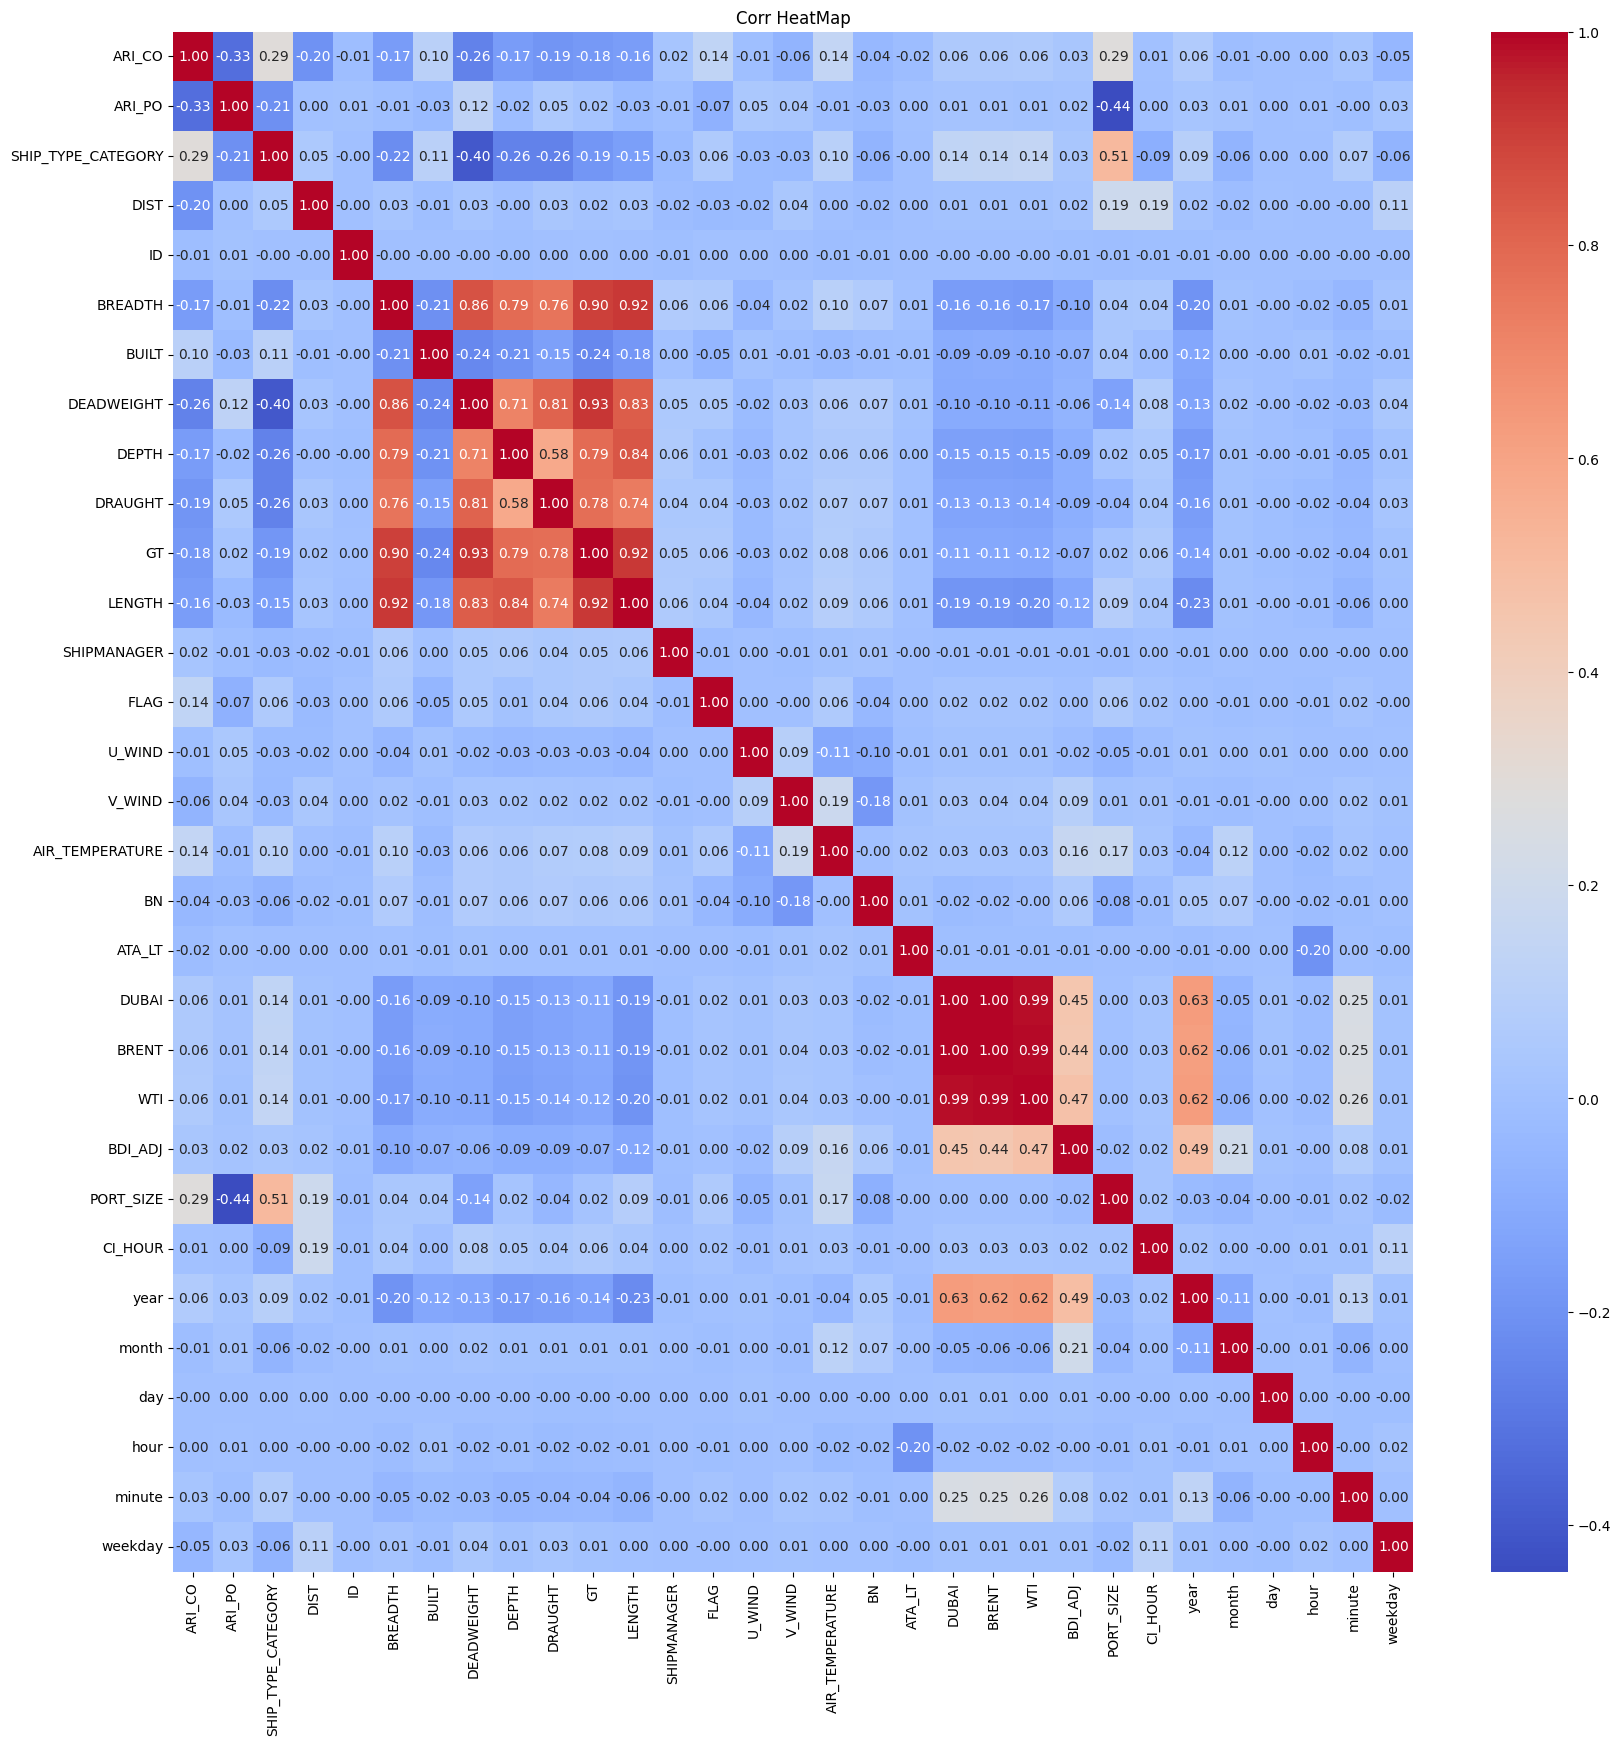

In [11]:
# df로부터 '상관계수 행렬'을 구한다.
train_correlation_matrix = train.corr()
# 상관관계를 시각화한다.
plt.figure(figsize=(20, 20))
sns.heatmap(train_correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Corr HeatMap")
plt.savefig('HD_ship_Corr.png',dpi=300)
plt.show()